# Python for Data Science Project Session 3: Economics and Finance

## Modern Portfolio Theory (MPT)

In the first part of the notebook we will optimise a portfolio consisting of two assets: Amazon (AMZN) and Alibaba (BABA) stock. We will implement the ideas of the Modern Portfolio Theory. Although to complete this notebook you don't need any knowledge about finance, if you want to learn more about MPT, you can do it [here](https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/modern-portfolio-theory-mpt/).

We start by importing packages required that we going to use in this notebook: numpy, pandas, pandas_datareader and matplotlib.

In [42]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yfin
import random
yfin.pdr_override()

Before we start working on data, first we must get them. In the first section of the notebook, we will be working on the daily prices of the Amazon and Alibaba stocks. First, we need to create dataframe `stock` and then using [DataReader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-yahoo) we can get the data from Yahoo Finance. The starting date of our data doesn't matter, but for sake of simplicity, let's start from 1st January 2016.

In [32]:
stock=pd.DataFrame()

In [33]:
stock['AMZN']= pdr.DataReader('AMZN','2016-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [34]:
stock['BABA']= pdr.DataReader('BABA','2016-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


Now, let's display our data to see if we correctly downloaded the data.

In [35]:
stock

,AMZN,BABA
Date,,
2016-01-04,31.849501,76.690002
2016-01-05,31.689501,78.629997
2016-01-06,31.632500,77.330002
2016-01-07,30.396999,72.720001
2016-01-08,30.352501,70.800003
...,...,...
2023-02-28,94.230003,87.790001
2023-03-01,92.169998,89.949997
2023-03-02,92.129997,89.750000


Once we get our data, we can create a table with daily logarithmic returns. To do this, we can use [`.log()`](https://numpy.org/doc/stable/reference/generated/numpy.log.html) and [`.shift()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html).

In [37]:
log_returns = np.log(stock/stock.shift(1))

Now let's display our returns!

In [38]:
log_returns

,AMZN,BABA
Date,,
2016-01-04,NaN,NaN
2016-01-05,-0.005036,0.024982
2016-01-06,-0.001800,-0.016671
2016-01-07,-0.039841,-0.061466
2016-01-08,-0.001465,-0.026757
...,...,...
2023-02-28,0.005000,-0.016494
2023-03-01,-0.022104,0.024306
2023-03-02,-0.000434,-0.002226


As we can see, our values are really small. It shouldn't concern us, since the returns are daily. What should concern us is the first row. Since there are no values before it, we have got NaN. To prevent any errors in the future, we can delete those values using [`.dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

In [39]:
log_returns.dropna()

,AMZN,BABA
Date,,
2016-01-05,-0.005036,0.024982
2016-01-06,-0.001800,-0.016671
2016-01-07,-0.039841,-0.061466
2016-01-08,-0.001465,-0.026757
2016-01-11,0.017456,-0.012507
...,...,...
2023-02-28,0.005000,-0.016494
2023-03-01,-0.022104,0.024306
2023-03-02,-0.000434,-0.002226


### Efficient Frontier

Now it's time to explain the basic assumptions of the Markowitz model. As we already know, we have two stocks with different returns. If our portfolio would consist only of the Amazon stock, our returns will be equal to Amazon stock returns, and the portfolio's variance would be equal to the Amazon stock variance. On the other hand, if our portfolio would consist only of Alibaba stock, our returns will be equal to Alibaba stock returns, and the portfolio's variance would be equal to the amazon stock variance. However, if our portfolio consist of mix of those two stocks, our returns and variability would be:

$$ returns = w_1 r_1+w_2 r_2\\ variance=w_1^2 v_1+w_2^2 v_2+2 w_1 w_2 cov() $$
$ w_1 - weight\,of\,1st\,stock\\ $ 
$ w_2 - weight\,of\,2nd\,stock\\ $ 
$ r_1 - returns\,of\,1st\,stock\\ $ 
$ r_2 - returns\,of\,2nd\,stock\\ $ 
$ v_1 - variance\,of\,1st\,stock\\ $ 
$ v_2 - variance\,of\,2nd\,stock\\ $ 
$ cov() - covariance\,of\,two\,stocks\\ $ 


Now, what we can observe is that while mixing the weights of two stocks, we can achieve two different combinations of stock 1 and stock 2 with the same variance, but with different returns. This could be nicely represented on a graph.

To create a curve that will represent all the possible combinations of two stocks, we will use random numbers. The idea is as follows. Once we create a sufficiently large number of random portfolios consisting of two stocks, it would create a sufficiently good representation of all possible combinations.

First, we need to create two empty arrays called returns and volatilities which we will expand by our randomly generated portfolios.

In [61]:
returns = []
volatility = []

Then, we need to create a loop that will execute a sufficiently large number of times (100 is enough). Within this loop, we need to generate one random number `ran` in range (0,1) which would be the weight of the first stock (you can use [`random.random()`](https://docs.python.org/3/library/random.html)). We don't need to generate the weight of the second stock, since it is just 1 - `ran` (because those two weights need to sum up to 1). Then we can append the arrays that we created before with the returns and volatility given randomly generated weight. The returns of the stocks we can get by taking the mean of the logarithmic returns calculated before (we need to multiply the mean daily returns by 250 to achieve annual returns because there are about 250 trading days in a year). We can get variances and covariance by using the [`.cov()`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) (note that this command returns covariance matrix, you need to use `.iloc[]` to get the values that you want, and you also need to multiply them by 250).

In [99]:
N=1000
for i in range(0,N):
    ran=random.random()
    returns.append(250*(ran*log_returns.mean()[0]+(1-ran)*log_returns.mean()[1]))
    volatility.append(np.square(ran)*log_returns.cov().iloc[0,0]+np.square(1-ran)*log_returns.cov().iloc[1,1]+2*ran*(1-ran)*log_returns.cov().iloc[1,0])

Let's display the values that we have calculated.

In [100]:
print(returns)
print(volatility)

[0.10293033022324026, 0.05358747836212202, 0.07863587650824327, 0.1266095714239767, 0.04969782059233219, 0.13452929203894715, 0.14891154886289357, 0.025620169827613355, 0.12624951974148463, 0.0976094590130813, 0.02427275036251056, 0.09396092184804034, 0.1306196683458167, 0.1027411538658689, 0.1473805368787264, 0.11948032733953437, 0.12029940219766913, 0.13994533629258182, 0.07524043435764433, 0.07620089700048015, 0.1229400901472431, 0.03487763981563666, 0.04864133227120744, 0.08249401371861925, 0.09733882954448747, 0.08010866214385545, 0.04500914349446079, 0.10784823404469744, 0.07644522900738634, 0.13189403030429725, 0.09600470690866894, 0.1282874287681558, 0.09169941547902942, 0.14770891353244814, 0.08898840588323267, 0.06780403151521605, 0.0342613266020607, 0.06092600654031924, 0.1385891907748235, 0.11338739328284503, 0.08938434492384185, 0.11566419068125883, 0.02798478150624603, 0.11644228338456417, 0.034309390972434975, 0.13577890603541584, 0.1396378870950713, 0.08838538167318334,

Now, we can plot our results. Create a scatter plot with volatility on the x-axis and returns on the y-axis.

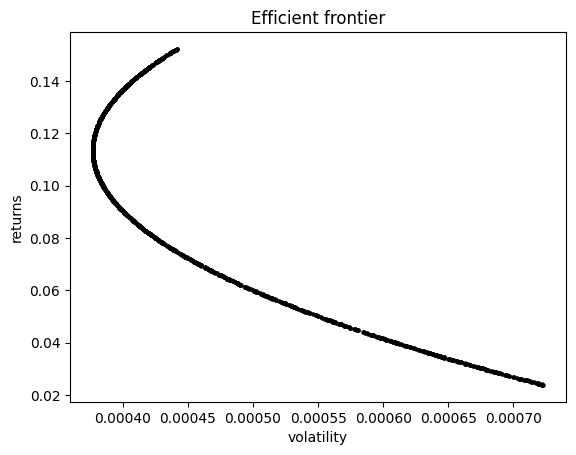

In [101]:
fig, ax = plt.subplots()
ax.scatter(volatility, returns,color='black',s=5)
ax.set_xlabel('volatility')
ax.set_ylabel('returns')
ax.set_title('Efficient frontier')
plt.show()

As we can see, our axes are not starting at 0. We can fix that by using [`.gca()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html), [`set_xlim()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim.html) and [`set_ylim()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html) .

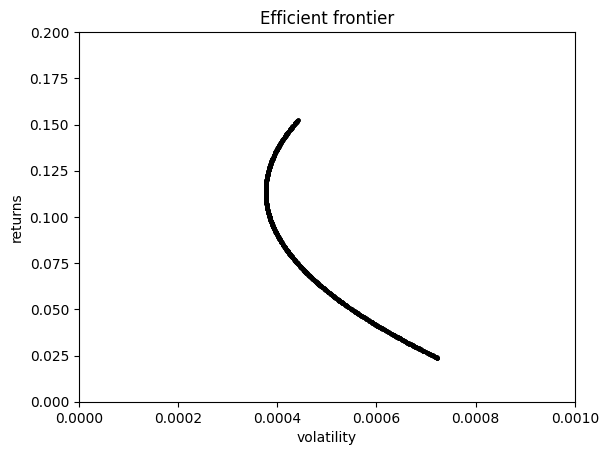

In [102]:
fig, ax = plt.subplots()
ax.scatter(volatility, returns,color='black',s=5)
ax=plt.gca
plt.xlim([0,0.001])
plt.ylim([0,0.2])
plt.xlabel('volatility')
plt.ylabel('returns')
plt.title('Efficient frontier')
plt.show()

The upper part of this curve is called "Efficient Frontier". It represents all the combinations of two assets that maximise the returns on the given level of risk (volatility). This notebook won't cover all the details about the Markowitz portfolio model, so if you want to learn more details about this model you can easily find them just by googling.

### Capital Allocation Line (CAL)

In this part of the notebook, we will calculate the Capital Allocation Line. That's the line that runs from the risk-free rate (the point where the returns are equal to the risk-free rate, and the volatility (risk) is equal to 0) and is tangent to our Efficient Frontier. This line shows all of the possible efficient allocations of the risk-free and risky assets. Once again, we won't go into details of the meaning of this line, we will just focus on computing it.

Let's begin by setting our risk-free rate, which would be stored in a variable called `interest_rate` (let's say that it is 0.1).

In [103]:
r = 0.1

Since in our example the Efficient Frontier is not a function but a set of points, to calculate the tangent line we will use a simple trick. To begin, let's calculate the equation of the line that goes through risk-free rate point and point (`volatilities[0]`, `returns[0]`). We can do it by creating linespace `x` and then calculating `y` by the following formula:

$$ y = risk\,free\,rate\,+\frac{return_0-risk\,free\,rate\,}{volatility_0}*x $$

In [104]:
x = np.linspace(0, 0.2)
y=r+((returns[0]-r)/volatility[0])*x

We can our line on top of the previous graph to see if it actually goes through our chosen points.

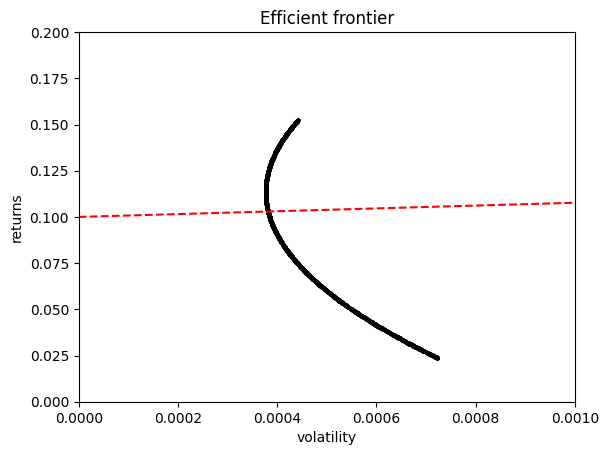

In [105]:
fig, ax = plt.subplots()
ax.scatter(volatility, returns,color='black',s=5)
ax=plt.gca
plt.plot(x,y,color='red',ls='--')
plt.xlim([0,0.001])
plt.ylim([0,0.2])
plt.xlabel('volatility')
plt.ylabel('returns')
plt.title('Efficient frontier')
plt.show()

Once we know how to compute the line that goes through chosen point, we can calculate the tangent line. To do this, we will use the property of the tangent line. In our case, the tangent line goes through one of the points on the line and lies above all the other points on our curve. What we need to do is find such a point, that the line that goes through it is above every other line. Let's create a matrix called `point` that would store the coordinates of our candidates for such point.

In [106]:
point=[volatility[0],returns[0]]
point

[0.00038154902566289636, 0.10293033022324026]

Now, what we need to do is to check if there is any other point that lies above it. If it does, it would become our new candidate for point of tangency. Once we try it for all points on our curve, our candidate will be our final point of tangency.

In [107]:
for i in range (0,100):
    if returns[i]>r+((point[1]-r)/point[0])*volatility[i]:
        point[0]=volatility[i]
        point[1]=returns[i]
    

Let's change the `y` that it represents the line that goes through risk-free rate and `point`.

In [108]:
y=r+((point[1]-r)/point[0])*x

Finally, we can plot everything together and confirm that the line that we have computed actually is tangent to our curve.

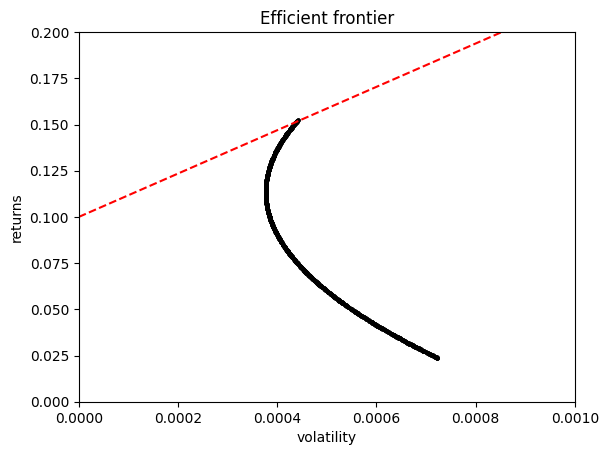

In [109]:
fig, ax = plt.subplots()
ax.scatter(volatility, returns,color='black',s=5)
ax=plt.gca
plt.plot(x,y,color='red',ls='--')
plt.xlim([0,0.001])
plt.ylim([0,0.2])
plt.xlabel('volatility')
plt.ylabel('returns')
plt.title('Efficient frontier')
plt.show()
# doesn't really work as there is not tangency portfolio, but this should still be maximized given a frontier without borrowing.

# 3x3 Nash equilibria

At the end of this notebook, we create a framework for finding nash equilibria in the 3x3 games.

Let's say that we have two firms. They are setting their level of cost spend on marketing. They could either spend 2, 3 or 4. If they spend the same amount, they both sell 4, so their profit is 4 minus marketing costs. If one of the firms spend more, it attracts a majority of clients and sells 7, and the other firm sells 1. The game could be represented by the following payoff matrix:

<table>
    <tr>
        <td></td><td></td><td>Firm 2</td><td></td><td></td>
    </tr>
    <tr>
        <td></td><td></td><td>Low</td><td>Medium</td><td>High</td>
    </tr>
    <tr>
        <td></td><td>Low</td><td>2;2</td><td>-1;4</td><td>-1;3</td>
    </tr>
    <tr>
        <td>Firm 1</td><td>Medium</td><td>4;-1</td><td>1;1</td><td>-2;3</td>
    </tr>
    <tr>
        <td></td><td>High</td><td>3;-1</td><td>3;-2</td><td>0;0</td>
    </tr>
    
</table>

To find the Nash Equilibria, we need to first create the matrix and fill it with payoffs. To create 2x3x3 matrix we can use [`.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).

In [115]:
payoffs = np.zeros((2,3,3))

Let's display our payoff matrix.

In [129]:
payoffs

array([[[ 2., -1., -1.],
        [ 4.,  1., -2.],
        [ 3.,  3.,  0.]],

       [[ 2., -1., -1.],
        [ 4.,  1., -2.],
        [ 3.,  3.,  0.]]])

For such a simple 3x3 game, we can easily enter the values manually, but to practise for other more complicated cases, we will create a function that returns one player given marketing expenditures. The function should be as follows:

 - if the players spend the same amount on marketing, return 4 - player's spending
 - if the player spends more than the opponent, return 7-player's spending 
 - if the player spends less than the opponent, return 1-player's spending

In [127]:
def payoff(player,opponent):
    if player ==opponent:
        return 4-player
    if player > opponent:
        return 7-player
    if player < opponent:
        return 1-player

Once you created the function you can fill the payoffs matrix with values.

In [170]:
for i in range(0, 3):
    for j in range (0, 3):
        payoffs[0,i,j]=payoff(i+2,j+2)
        payoffs[1,i,j]=payoff(j+2,i+2)

Now check if you have correctly filled the matrix.

In [171]:
payoffs

array([[[ 2., -1., -1.],
        [ 4.,  1., -2.],
        [ 3.,  3.,  0.]],

       [[ 2.,  4.,  3.],
        [-1.,  1.,  3.],
        [-1., -2.,  0.]]])

Now given the payoff matrix we can compute Best Responses. Best Response for some choice of your opponent is the choice that gives no less than any other choice e.g. choosing medium is the best response of player 1 to player 2 choosing low. Let's use `.zeros()` and create the matrix of the same size as the payoff matrix filled with zeros. If the strategy is the best response, we will change the value to 1 (so for example, for player 1 playing low with response to low is not the best response, since playing medium gives higher payoff, but if player 1 plays medium with response to low, he doesn't have any other response that gives qual or higher payoff, so for player 1 paying medium is the best response to low). Let's create a loop that goes through every value in the best response matrix and checks whether it is the best response.

In [183]:
br = np.zeros((2,3,3))

In [184]:
for i in range(0, 3):
    for j in range (0, 3):
        count=0
        for k in range (0,3):
#given opp strategy j, does strategy i perform better than alternatives k
            if (payoffs[0,i,j]>=payoffs[0,k,j]):
                count=count+1
                if count ==3:
                    br[0,i,j]=1
#for opponent
for i in range(0, 3):
    for j in range (0, 3):
        count=0
        for k in range (0,3):
            if (payoffs[1,j,i]>=payoffs[1,j,k]):
                count=count+1
                if count ==3:
                    br[1,j,i]=1

In [185]:
br

array([[[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 1.]],

       [[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]]])

If the strategy is the best response for both player 1 and player 2, no one has any incentives to change their choice and we are in the Nash Equilibrium. We can create an empty array called `nash_equilibria` and run a loop that checks if the given strategy is the best response for both players 1 and 2.

In [188]:
NE =np.zeros((3,3))

In [189]:
for i in range(0,3):
    for j in range(0,3):
        if(br[0,i,j]==1 and br[0,i,j]==br[1,i,j]):
            NE[i,j]=1

Now, we can display our Nash Equilibria.

In [190]:
NE

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.]])